In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# USER INPUTS

In [2]:
# Majority Level
# The majority level sets the percentage of the census tract population that must self-identify as the same 
# race/ethnicity in order for the census tract to be classified as that race/ethnicity. We had defined majority 
# as 50% and strong-majority as 75%.
majority_level = 50

# LOAD DATA

In [3]:
# Demographic Data
# ACS 2015 Planning database available at https://www.census.gov/data/datasets/2015/adrm/research/2015-planning-database.html 
DemographicData = pd.read_csv('PDB_2015_Tract.csv', encoding = "ISO-8859-1")
DemographicData = DemographicData[['GIDTR', 'Renter_Occp_HU_ACS_09_13', 'Owner_Occp_HU_ACS_09_13', 
                         'pct_NH_Asian_alone_ACS_09_13', 'pct_NH_Blk_alone_ACS_09_13',
                         'pct_Hispanic_ACS_09_13', 'pct_NH_White_alone_ACS_09_13',
                         'Med_HHD_Inc_ACS_09_13']]

In [4]:
# Project Sunroof Data
# Updated data can be found at https://www.google.com/get/sunroof/data-explorer/
SunroofData = pd.read_csv('project-sunroof-census_tract.csv')
SunroofData = SunroofData[['region_name', 'count_qualified', 'existing_installs_count', 'percent_covered', 'percent_qualified']]

# CLEAN DATA

In [5]:
# Convert median household income from a string to a float
DemographicData['Med_HHD_Inc_ACS_09_13'] = DemographicData['Med_HHD_Inc_ACS_09_13'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Merge Google Project Sunroof data with Demographic data from ACS
data = SunroofData.merge(DemographicData,left_on='region_name',right_on='GIDTR')

# Remove census tracts where Google Project Sunroof analyzed < 95% of all buildings in the census tract.
data = data[data.percent_covered >= 95]

# Remove census tracts where there is no potential to install rooftop PV
data = data[data.percent_qualified !=0]

# Remove census tracts with median household income below the 2013 poverty threshold for a 4-person household 
# https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-poverty-thresholds.html
data = data[data.Med_HHD_Inc_ACS_09_13 >= 23834] 

# Sort by Income
data = data.sort_values(by = 'Med_HHD_Inc_ACS_09_13')

data = data.reset_index(drop=True)

In [6]:
# Check for missing data
np.isnan(data).any()

region_name                     False
count_qualified                 False
existing_installs_count         False
percent_covered                 False
percent_qualified               False
GIDTR                           False
Renter_Occp_HU_ACS_09_13        False
Owner_Occp_HU_ACS_09_13         False
pct_NH_Asian_alone_ACS_09_13    False
pct_NH_Blk_alone_ACS_09_13      False
pct_Hispanic_ACS_09_13          False
pct_NH_White_alone_ACS_09_13    False
Med_HHD_Inc_ACS_09_13           False
dtype: bool

# ASSIGN INCOME DECILE

In [7]:
# Generate 10 income bins with the same number of datapoints in each
number_of_bins = 10 # To establish income deciles
index_increment = int(np.floor(len(data)/number_of_bins))
income_bins = []
for i in range(1,number_of_bins):
    income_bins.append(data.Med_HHD_Inc_ACS_09_13[index_increment*i])

# Assign each census tract to an income decile   
data['income_decile'] = number_of_bins
for i in range(0,len(income_bins)):
    data.loc[data['Med_HHD_Inc_ACS_09_13'] <= income_bins[len(income_bins)-i-1], 'income_decile'] = len(income_bins)-i

# GROUP CENSUS TRACTS BY THEIR MAJORITY RACE/ETHNICITY

In [8]:
# Create dataframes for each race/ethnicity in the study
df_asian       = pd.DataFrame(columns=['median_income', 'income_decile', 'existing_installs_count'])
df_black       = pd.DataFrame(columns=['median_income', 'income_decile', 'existing_installs_count'])
df_hisp        = pd.DataFrame(columns=['median_income', 'income_decile', 'existing_installs_count'])
df_white       = pd.DataFrame(columns=['median_income', 'income_decile', 'existing_installs_count'])
df_no_majority = pd.DataFrame(columns=['median_income', 'income_decile', 'existing_installs_count'])

#Filter data by majority level to populate each race/ethnicity dataframe
for i in range(0, len(data)):
    if data['pct_NH_Asian_alone_ACS_09_13'].iloc[i] >= majority_level:
        df_asian.loc[i] = [data['Med_HHD_Inc_ACS_09_13'][i], data['income_decile'][i], data['existing_installs_count'][i]]
    elif data['pct_NH_Blk_alone_ACS_09_13'].iloc[i] >= majority_level:
        df_black.loc[i] = [data['Med_HHD_Inc_ACS_09_13'][i], data['income_decile'][i], data['existing_installs_count'][i]]
    elif data['pct_Hispanic_ACS_09_13'].iloc[i] >= majority_level:
        df_hisp.loc[i] = [data['Med_HHD_Inc_ACS_09_13'][i], data['income_decile'][i], data['existing_installs_count'][i]]
    elif data['pct_NH_White_alone_ACS_09_13'].iloc[i] >= majority_level:
        df_white.loc[i] = [data['Med_HHD_Inc_ACS_09_13'][i], data['income_decile'][i], data['existing_installs_count'][i]]
    else:
        df_no_majority.loc[i] = [data['Med_HHD_Inc_ACS_09_13'][i], data['income_decile'][i], data['existing_installs_count'][i]]

# CREATE FIGURES

## Figure Showing Percent of Census Tracts Without Rooftop PV By Race and Ethnicity

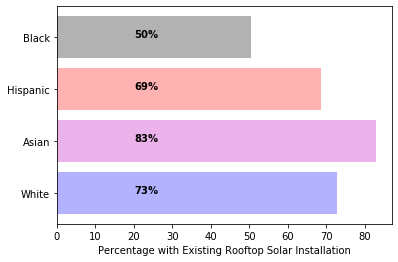

In [9]:
plt.barh('White', len(df_white[df_white.existing_installs_count != 0])/len(df_white)*100, color='b', alpha = 0.3)
plt.barh('Asian', len(df_asian[df_asian.existing_installs_count != 0])/len(df_asian)*100, color='m', alpha = 0.3)
plt.barh('Hispanic', len(df_hisp[df_hisp.existing_installs_count != 0])/len(df_hisp)*100, color='r', alpha = 0.3)
plt.barh('Black', len(df_black[df_black.existing_installs_count != 0])/len(df_black)*100, color='black', alpha = 0.3)

y = [len(df_white[df_white.existing_installs_count != 0])/len(df_white)*100,
     len(df_asian[df_asian.existing_installs_count != 0])/len(df_asian)*100,
     len(df_hisp[df_hisp.existing_installs_count != 0])/len(df_hisp)*100,
     len(df_black[df_black.existing_installs_count != 0])/len(df_black)*100
    ]

for i, v in enumerate(y):
    plt.text(20, i, str(round(v))+'%', color='black', fontweight='bold')

plt.xlabel('Percentage with Existing Rooftop Solar Installation')

plt.show()

## Previous Figure Segmented by Household Income Decile

In [10]:
ratio_asian = []
ratio_black = []
ratio_hisp = []
ratio_white = []
ratio_no_majority = []

for N in range(1,number_of_bins+1):
    df_asian_income_decile = df_asian[df_asian.income_decile == N]
    ratio_asian.append(len(df_asian_income_decile[df_asian_income_decile.existing_installs_count == 0])/len(df_asian_income_decile))
    
    df_black_income_decile = df_black[df_black.income_decile == N]
    ratio_black.append(len(df_black_income_decile[df_black_income_decile.existing_installs_count == 0])/len(df_black_income_decile))
    
    df_hisp_income_decile = df_hisp[df_hisp.income_decile == N]
    ratio_hisp.append(len(df_hisp_income_decile[df_hisp_income_decile.existing_installs_count == 0])/len(df_hisp_income_decile))
    
    df_white_income_decile = df_white[df_white.income_decile == N]
    ratio_white.append(len(df_white_income_decile[df_white_income_decile.existing_installs_count == 0])/len(df_white_income_decile))
    
    df_no_majority_income_decile = df_no_majority[df_no_majority.income_decile == N]
    ratio_no_majority.append(len(df_no_majority_income_decile[df_no_majority_income_decile.existing_installs_count == 0])/len(df_no_majority_income_decile))

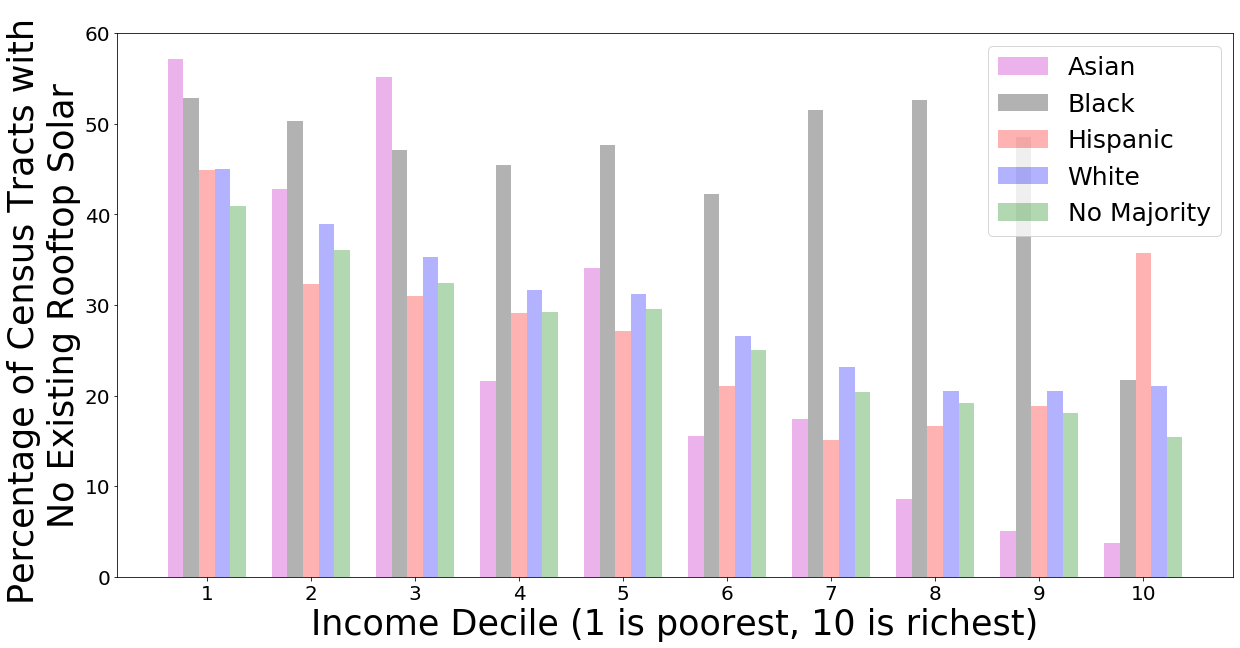

In [11]:
ind = np.arange(number_of_bins)  # the x locations for the groups
width = 0.15                     # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(ind, list(np.array(ratio_asian)*100), width, color='m', alpha = 0.3)
rects2 = ax.bar(ind + width, list(np.array(ratio_black)*100), width, color='black', alpha = 0.3)
rects3 = ax.bar(ind + width*2, list(np.array(ratio_hisp)*100), width, color='red', alpha = 0.3)
rects4 = ax.bar(ind + width*3, list(np.array(ratio_white)*100), width, color='blue', alpha = 0.3)
rects5 = ax.bar(ind + width*4, list(np.array(ratio_no_majority)*100), width, color='green', alpha = 0.3)

ax.set_ylabel('Percentage of Census Tracts with \nNo Existing Rooftop Solar', fontsize =35)
ax.set_xlabel('Income Decile (1 is poorest, 10 is richest)', fontsize = 35)
ax.set_xticks(ind + width *2)
ax.set_xticklabels(('1','2','3','4','5','6','7','8','9','10'), fontsize = 40)
ax.tick_params(labelsize=20)

ax.legend((rects1[0], rects2[0], rects3[0], rects4[0], rects5[0]), ('Asian','Black', 'Hispanic', 'White', 'No Majority'), loc = 'upper right', fontsize = 25)
ax.patch.set_facecolor('white')

plt.show()

## Figure Showing Number of Census Tracts by Race and Ethnicity in Each Household Income Decile

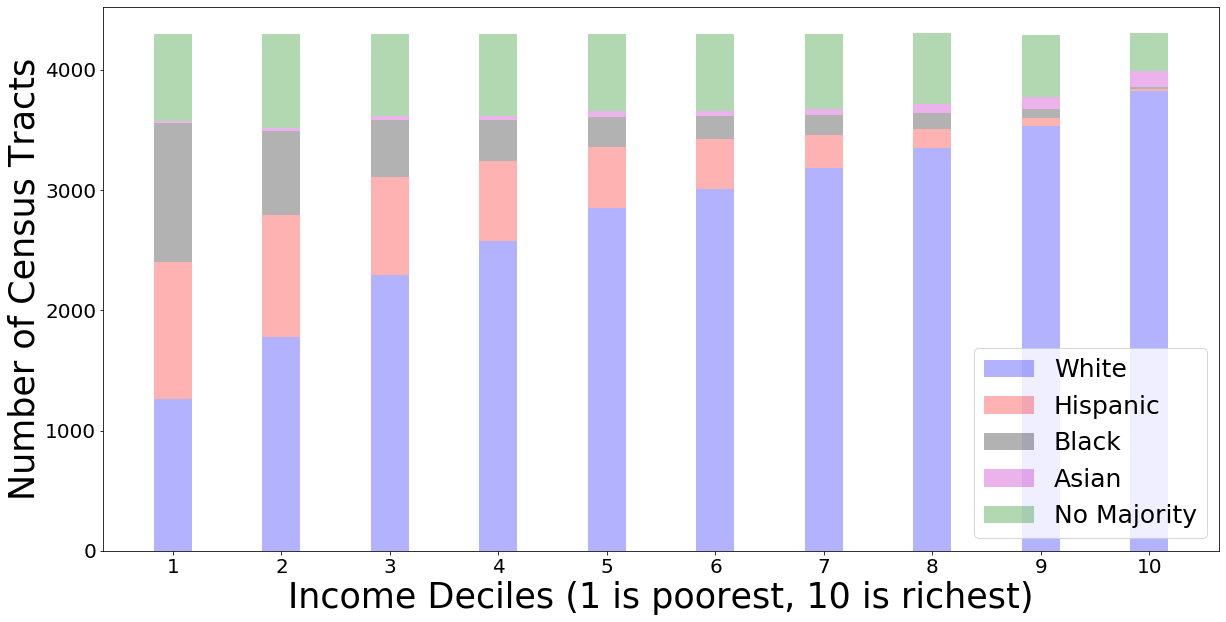

In [12]:
fig, ax = plt.subplots(figsize=(20,10))

ind = np.arange(number_of_bins)
width = 0.35

count_asian = []
count_black = []
count_hisp = []
count_white = []
count_no_majority = []

for N in range(1,number_of_bins+1):
    df_white_income_decile = df_white[df_white.income_decile == N]
    count_white.append(len(df_white_income_decile))
    
    df_hisp_income_decile = df_hisp[df_hisp.income_decile == N]
    count_hisp.append(len(df_hisp_income_decile))
    
    df_black_income_decile = df_black[df_black.income_decile == N]
    count_black.append(len(df_black_income_decile))
    
    df_asian_income_decile = df_asian[df_asian.income_decile == N]
    count_asian.append(len(df_asian_income_decile))
    
    df_no_majority_income_decile = df_no_majority[df_no_majority.income_decile == N]
    count_no_majority.append(len(df_no_majority_income_decile))

ax.bar(ind, count_white, width, label ='White', color ='blue', alpha = 0.3)
ax.bar(ind, count_hisp, width, bottom = count_white,
       label = 'Hispanic', color = 'red', alpha = 0.3)
ax.bar(ind, count_black, width, bottom = list(np.array(count_hisp)+np.array(count_white)),
       label = 'Black', color = 'black', alpha = 0.3)
ax.bar(ind, count_asian, width, bottom = list(np.array(count_hisp)+np.array(count_white)+np.array(count_black)),
       label = 'Asian', color = 'm', alpha = 0.3)
ax.bar(ind, count_no_majority, width, bottom = list(np.array(count_hisp)+np.array(count_white)+np.array(count_black)+np.array(count_asian)),
       label = 'No Majority', color = 'g', alpha = 0.3)

ax.legend(loc='lower right' , fontsize = 25)
ax.set_ylabel('Number of Census Tracts', fontsize=35)
ax.set_xlabel('Income Deciles (1 is poorest, 10 is richest)', fontsize=35)
plt.xticks(ind, ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'), fontsize=35)
ax.tick_params(labelsize=20)

plt.show()